In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#load data

data = pd.read_csv('Training_Data-1.csv')

In [3]:
data.dtypes

DATE                                                                  object
WEEK#                                                                  int64
PLAY-ID                                                                int64
DRIVE-ID                                                               int64
QUARTER                                                                int64
REMAINING TIME IN THE QUARTER (mm:ss)                                 object
DOWN                                                                 float64
TO GO                                                                  int64
YARD LINE 0-100                                                        int64
OFFENSIVE TEAM                                                        object
DEFENSIVE TEAM                                                        object
OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral                        object
POINTS SCORED\nBY EITHER TEAM                                        float64

In [7]:
#removing \n from the columns
data.columns = data.columns.str.replace('\n', '')

# Change column names to lower case and remove spaces
new_columns = data.columns.str.lower().str.replace(' ', '_')
data.columns = new_columns

# remove apostrophe (')
data.columns = data.columns.str.replace("'", "", regex=False)

#remove commas
data.columns = data.columns.str.replace(',', '_', regex=False)

print(data.columns)


Index(['date', 'week#', 'play-id', 'drive-id', 'quarter',
       'remaining_time_in_the_quarter_(mm:ss)', 'down', 'to_go',
       'yard_line_0-100', 'offensive_team', 'defensive_team',
       'offensive_team_venue_road_home_neutral', 'points_scoredby_either_team',
       'road_teams_accumulated_score', 'home_teams_accumulated_score',
       'scoredifferential(home_teams_score)_-(road_teams_score)', 'play_type',
       'yards_gained'],
      dtype='object')


In [9]:
# check null values
null_values = data.isnull().sum()

# Calculate the percentage of null values
null_percentage = (null_values / len(data)) * 100

# Create a dataframe with null value information
null_info = pd.DataFrame({
    'Null Count': null_values,
    'Null Percentage': null_percentage
})

# Sort the dataframe by null count in descending order
null_info = null_info.sort_values('Null Count', ascending=False)

# Display only columns with null values
null_info = null_info[null_info['Null Count'] > 0]

print("Columns with null values:")
print(null_info)

Columns with null values:
                             Null Count  Null Percentage
points_scoredby_either_team       32590        95.974320
yards_gained                       8013        23.597491
down                                121         0.356333


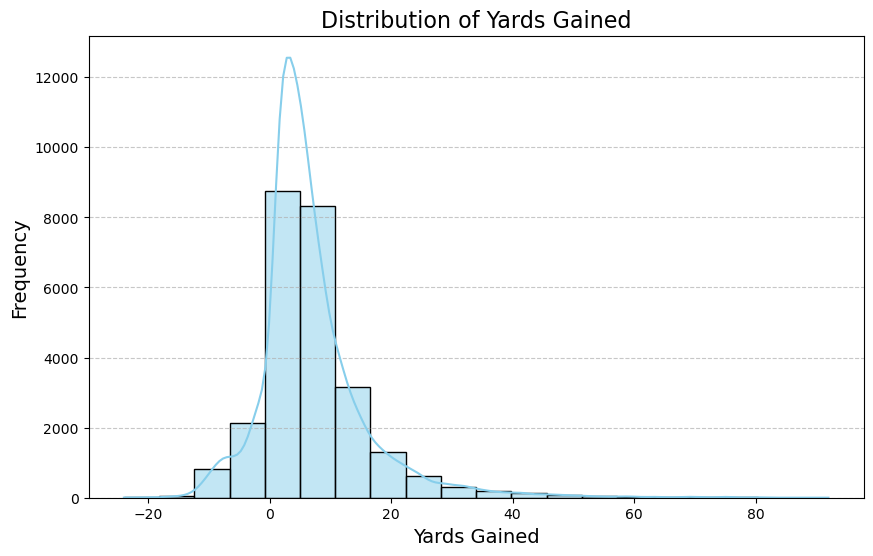

In [11]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data.yards_gained, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Yards Gained', fontsize=16)
plt.xlabel('Yards Gained', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [13]:
#drop points_scored and down
data = data.drop(columns = ['points_scoredby_either_team'])

#handling missing values for yards_gained variable
for play_type in data['play_type'].unique():
    median_yards = data[data['play_type'] == play_type]['yards_gained'].median()
    data.loc[(data['play_type'] == play_type) & (data['yards_gained'].isnull()), 'yards_gained'] = median_yards

#drop the records from down variable
data = data.dropna(subset=['down'])


In [15]:
data.shape

(33836, 17)

In [17]:
#rechecking null values
null = data.isnull().sum()
print(null)

date                                                       0
week#                                                      0
play-id                                                    0
drive-id                                                   0
quarter                                                    0
remaining_time_in_the_quarter_(mm:ss)                      0
down                                                       0
to_go                                                      0
yard_line_0-100                                            0
offensive_team                                             0
defensive_team                                             0
offensive_team_venue_road_home_neutral                     0
road_teams_accumulated_score                               0
home_teams_accumulated_score                               0
scoredifferential(home_teams_score)_-(road_teams_score)    0
play_type                                                  0
yards_gained            

In [19]:
#convert the 'remaining time seconds' column from minutes to seconds 
def convert_to_seconds(time_str):
    parts = time_str.split(':')
    return int(parts[0]) * 60 + int(parts[1])

data['remaining_time_seconds'] = data['remaining_time_in_the_quarter_(mm:ss)'].apply(convert_to_seconds)

print(data[['remaining_time_in_the_quarter_(mm:ss)', 'remaining_time_seconds']].head())
data = data.drop(columns = ['remaining_time_in_the_quarter_(mm:ss)'])

  remaining_time_in_the_quarter_(mm:ss)  remaining_time_seconds
0                                 15:00                     900
1                                 14:29                     869
2                                 14:25                     865
3                                 14:09                     849
4                                 13:34                     814


Outliers in 'to_go' column:
45       20
56       17
95       22
122      20
123      20
         ..
33791    17
33799    17
33913    20
33926    30
33927    24
Name: to_go, Length: 1113, dtype: int64
Number of outliers: 1113
Percentage of outliers: 3.29%


Outliers in 'yard_line_0-100' column:
Series([], Name: yard_line_0-100, dtype: int64)
Number of outliers: 0
Percentage of outliers: 0.00%

Descriptive statistics for 'to_go':
count    33836.000000
mean         8.452890
std          3.949683
min          1.000000
25%          6.000000
50%         10.000000
75%         10.000000
max         40.000000
Name: to_go, dtype: float64

Descriptive statistics for 'yard_line_0-100':
count    33836.000000
mean        51.225145
std         24.177302
min          1.000000
25%         33.000000
50%         55.000000
75%         72.000000
max         99.000000
Name: yard_line_0-100, dtype: float64


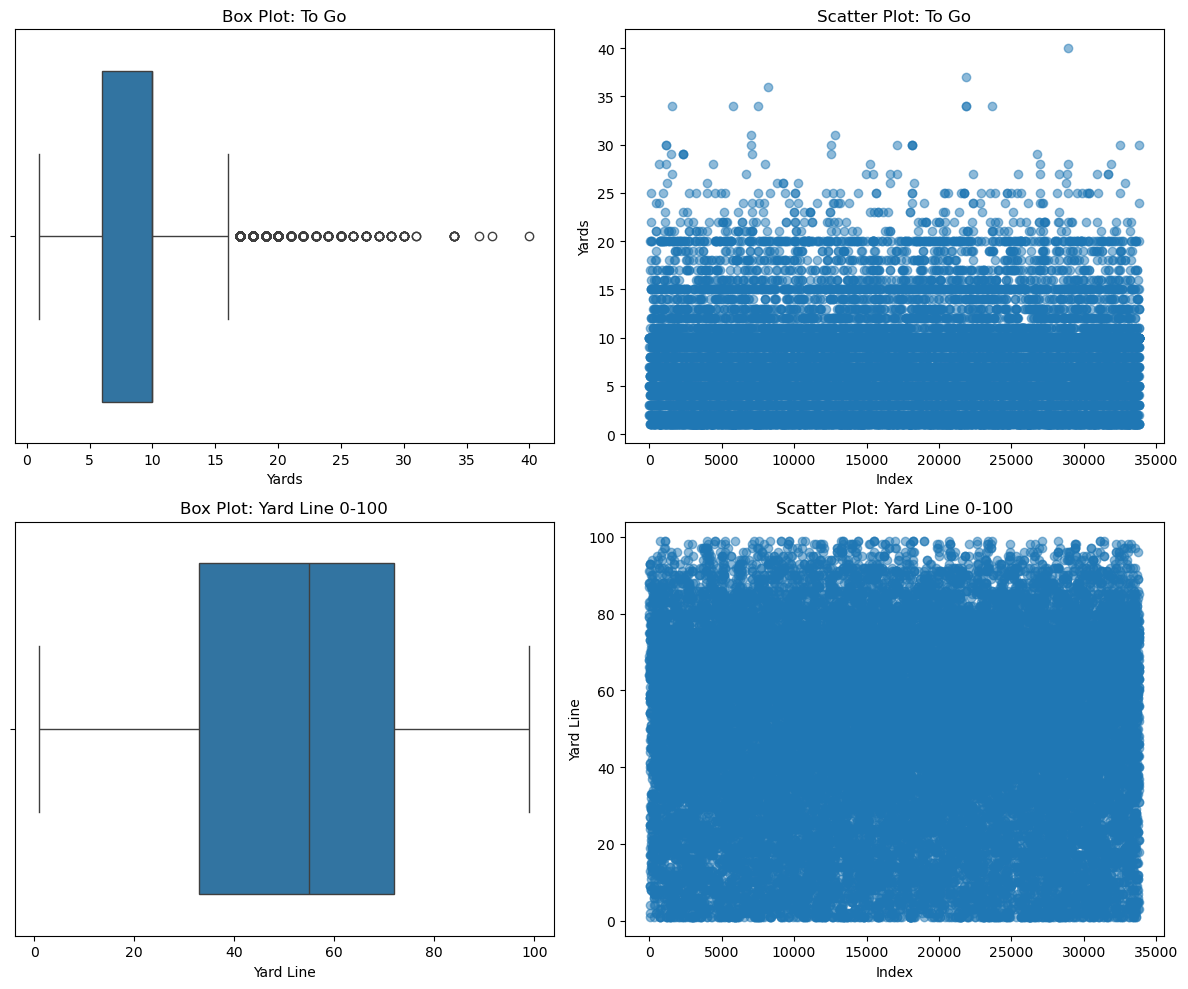

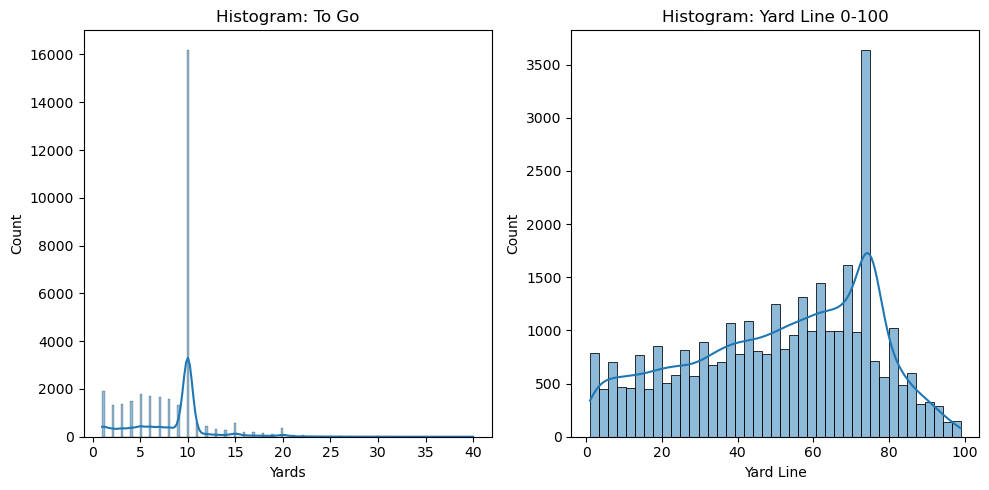

In [21]:
#checking outliers in numerical columns
def find_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Check outliers in 'to_go' column
to_go_outliers = find_outliers_iqr(data['to_go'])
print("Outliers in 'to_go' column:")
print(to_go_outliers)
print(f"Number of outliers: {len(to_go_outliers)}")
print(f"Percentage of outliers: {(len(to_go_outliers) / len(data['to_go'])) * 100:.2f}%")

print("\n")

# Check outliers in 'yard_line_0-100' column
yard_line_outliers = find_outliers_iqr(data['yard_line_0-100'])
print("Outliers in 'yard_line_0-100' column:")
print(yard_line_outliers)
print(f"Number of outliers: {len(yard_line_outliers)}")
print(f"Percentage of outliers: {(len(yard_line_outliers) / len(data['yard_line_0-100'])) * 100:.2f}%")

# Descriptive statistics for context
print("\nDescriptive statistics for 'to_go':")
print(data['to_go'].describe())

print("\nDescriptive statistics for 'yard_line_0-100':")
print(data['yard_line_0-100'].describe())

# Visualizations
plt.figure(figsize=(12, 10))

# Box plot for 'to_go'
plt.subplot(2, 2, 1)
sns.boxplot(x=data['to_go'])
plt.title("Box Plot: To Go")
plt.xlabel("Yards")

# Scatter plot for 'to_go'
plt.subplot(2, 2, 2)
plt.scatter(range(len(data['to_go'])), data['to_go'], alpha=0.5)
plt.title("Scatter Plot: To Go")
plt.xlabel("Index")
plt.ylabel("Yards")

# Box plot for 'yard_line_0-100'
plt.subplot(2, 2, 3)
sns.boxplot(x=data['yard_line_0-100'])
plt.title("Box Plot: Yard Line 0-100")
plt.xlabel("Yard Line")

# Scatter plot for 'yard_line_0-100'
plt.subplot(2, 2, 4)
plt.scatter(range(len(data['yard_line_0-100'])), data['yard_line_0-100'], alpha=0.5)
plt.title("Scatter Plot: Yard Line 0-100")
plt.xlabel("Index")
plt.ylabel("Yard Line")

plt.tight_layout()
plt.show()

# Histogram for 'to_go'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['to_go'], kde=True)
plt.title("Histogram: To Go")
plt.xlabel("Yards")

# Histogram for 'yard_line_0-100'
plt.subplot(1, 2, 2)
sns.histplot(data['yard_line_0-100'], kde=True)
plt.title("Histogram: Yard Line 0-100")
plt.xlabel("Yard Line")

plt.tight_layout()
plt.show()

Outliers in 'scoredifferential(home_teams_score)_-(road_teams_score)' column:
880     -23
881     -23
882     -23
883     -23
884     -23
         ..
33677    24
33678    24
33679    24
33680    24
33681    24
Name: scoredifferential(home_teams_score)_-(road_teams_score), Length: 1756, dtype: int64
Number of outliers: 1756
Percentage of outliers: 5.19%


Outliers in 'remaining_time_seconds' column:
Series([], Name: remaining_time_seconds, dtype: int64)
Number of outliers: 0
Percentage of outliers: 0.00%


Outliers in 'road_teams_accumulated_score' column:
1530     36
1531     36
1532     36
1533     36
1534     36
         ..
28813    36
28814    36
28815    36
33323    38
33324    38
Name: road_teams_accumulated_score, Length: 277, dtype: int64
Number of outliers: 277
Percentage of outliers: 0.82%


Outliers in 'home_teams_accumulated_score' column:
4765     41
4766     42
4767     42
4768     42
4769     42
         ..
32386    41
32387    47
32388    48
32389    48
32390    48
Name:

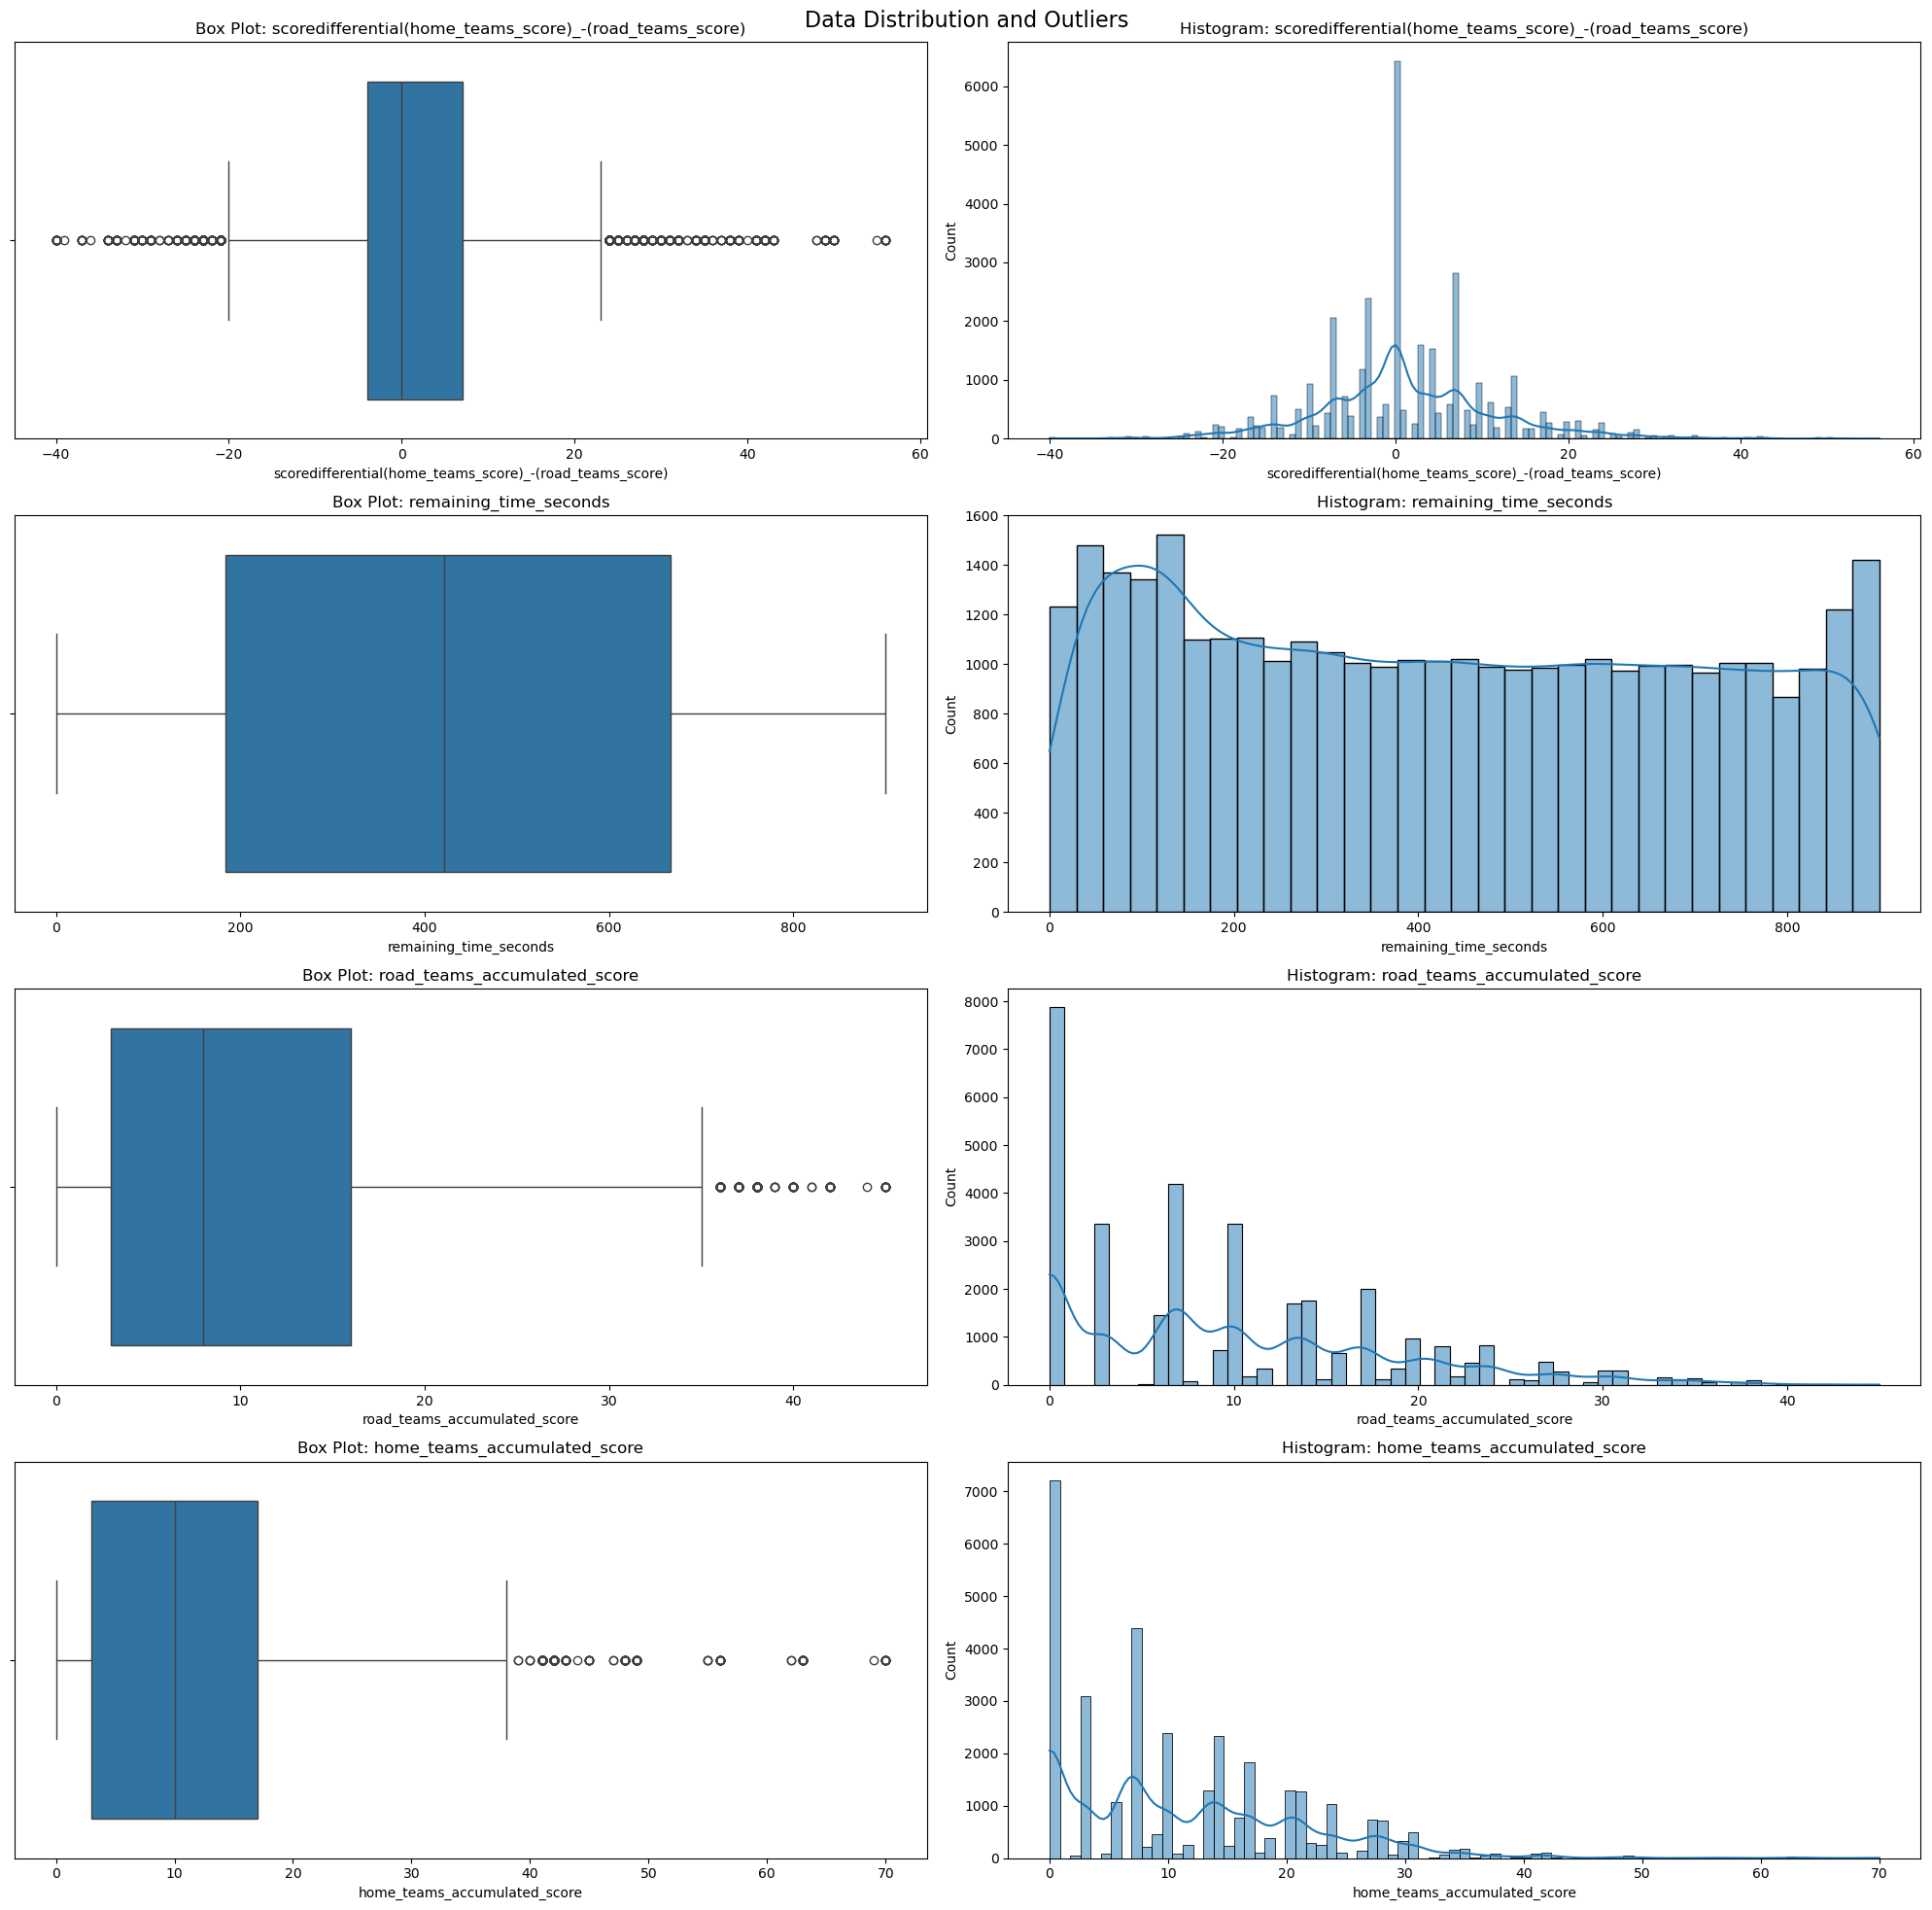

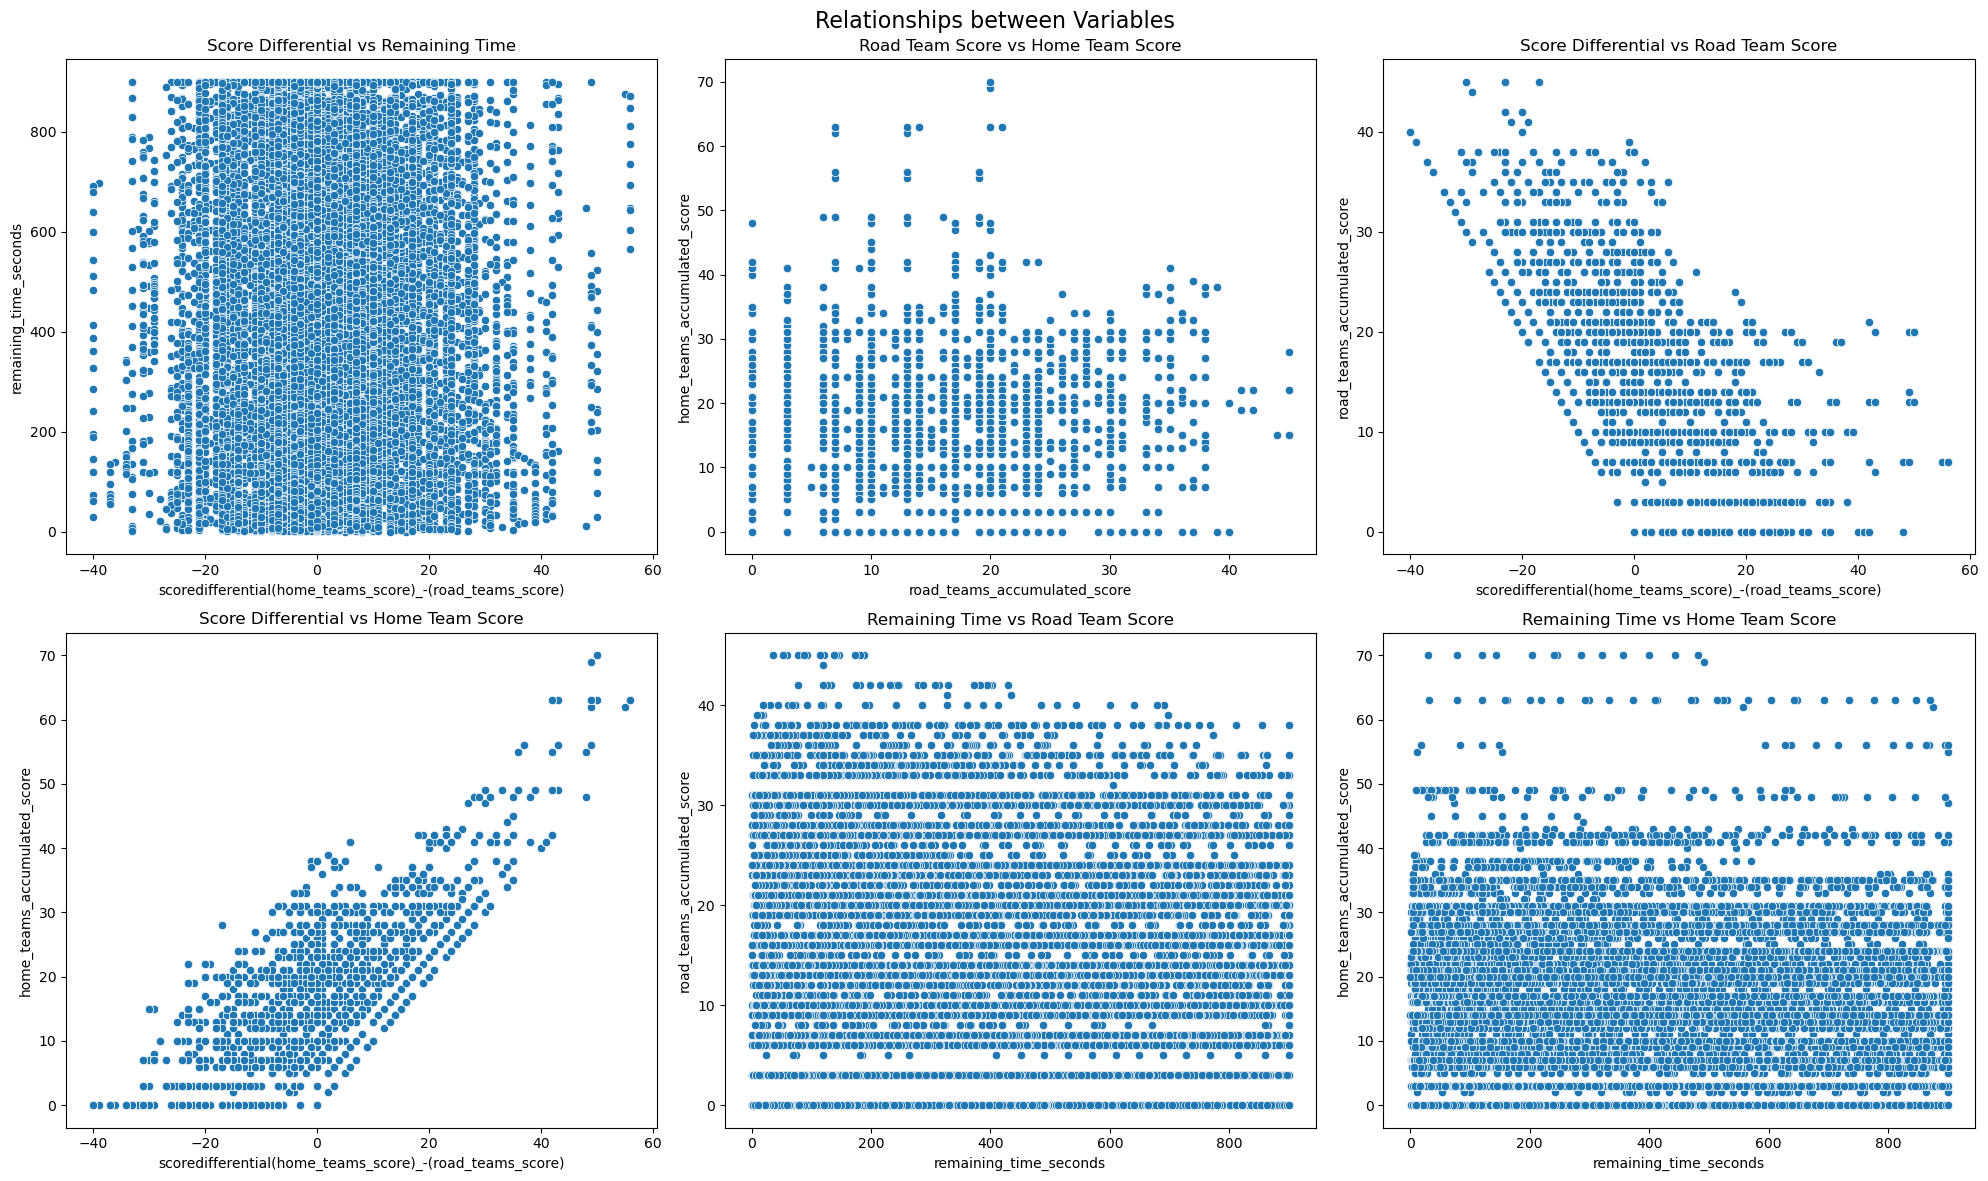


Descriptive statistics for checked columns:
       scoredifferential(home_teams_score)_-(road_teams_score)  \
count                                       33836.000000         
mean                                            1.357519         
std                                            10.497761         
min                                           -40.000000         
25%                                            -4.000000         
50%                                             0.000000         
75%                                             7.000000         
max                                            56.000000         

       remaining_time_seconds  road_teams_accumulated_score  \
count            33836.000000                  33836.000000   
mean               432.074566                     10.003665   
std                270.772868                      8.936949   
min                  0.000000                      0.000000   
25%                184.000000                

In [22]:
def find_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

columns_to_check = ['scoredifferential(home_teams_score)_-(road_teams_score)', 'remaining_time_seconds', 'road_teams_accumulated_score', 'home_teams_accumulated_score']

# Create a figure with subplots for each column
fig, axs = plt.subplots(len(columns_to_check), 2, figsize=(20, 5*len(columns_to_check)))
fig.suptitle('Data Distribution and Outliers', fontsize=16)

for i, col in enumerate(columns_to_check):
    outliers = find_outliers_iqr(data[col])
    print(f"Outliers in '{col}' column:")
    print(outliers)
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers) / len(data[col])) * 100:.2f}%")
    print("\n")
    
    # Box plot
    sns.boxplot(x=data[col], ax=axs[i, 0])
    axs[i, 0].set_title(f'Box Plot: {col}')
    axs[i, 0].set_xlabel(col)
    
    # Histogram with KDE
    sns.histplot(data[col], kde=True, ax=axs[i, 1])
    axs[i, 1].set_title(f'Histogram: {col}')
    axs[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

# Scatter plots to visualize relationships between variables
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Relationships between Variables', fontsize=16)

sns.scatterplot(data=data, x='scoredifferential(home_teams_score)_-(road_teams_score)', y='remaining_time_seconds', ax=axs[0, 0])
axs[0, 0].set_title('Score Differential vs Remaining Time')

sns.scatterplot(data=data, x='road_teams_accumulated_score', y='home_teams_accumulated_score', ax=axs[0, 1])
axs[0, 1].set_title('Road Team Score vs Home Team Score')

sns.scatterplot(data=data, x='scoredifferential(home_teams_score)_-(road_teams_score)', y='road_teams_accumulated_score', ax=axs[0, 2])
axs[0, 2].set_title('Score Differential vs Road Team Score')

sns.scatterplot(data=data, x='scoredifferential(home_teams_score)_-(road_teams_score)', y='home_teams_accumulated_score', ax=axs[1, 0])
axs[1, 0].set_title('Score Differential vs Home Team Score')

sns.scatterplot(data=data, x='remaining_time_seconds', y='road_teams_accumulated_score', ax=axs[1, 1])
axs[1, 1].set_title('Remaining Time vs Road Team Score')

sns.scatterplot(data=data, x='remaining_time_seconds', y='home_teams_accumulated_score', ax=axs[1, 2])
axs[1, 2].set_title('Remaining Time vs Home Team Score')

plt.tight_layout()
plt.show()

# Descriptive statistics for context
print("\nDescriptive statistics for checked columns:")
print(data[columns_to_check].describe())


Descriptive statistics after handling outliers:
       home_teams_accumulated_score  road_teams_accumulated_score
count                  33836.000000                  33836.000000
mean                      11.269742                      9.980302
std                        9.665704                      8.863739
min                        0.000000                      0.000000
25%                        3.000000                      3.000000
50%                       10.000000                      8.000000
75%                       17.000000                     16.000000
max                       38.000000                     35.500000


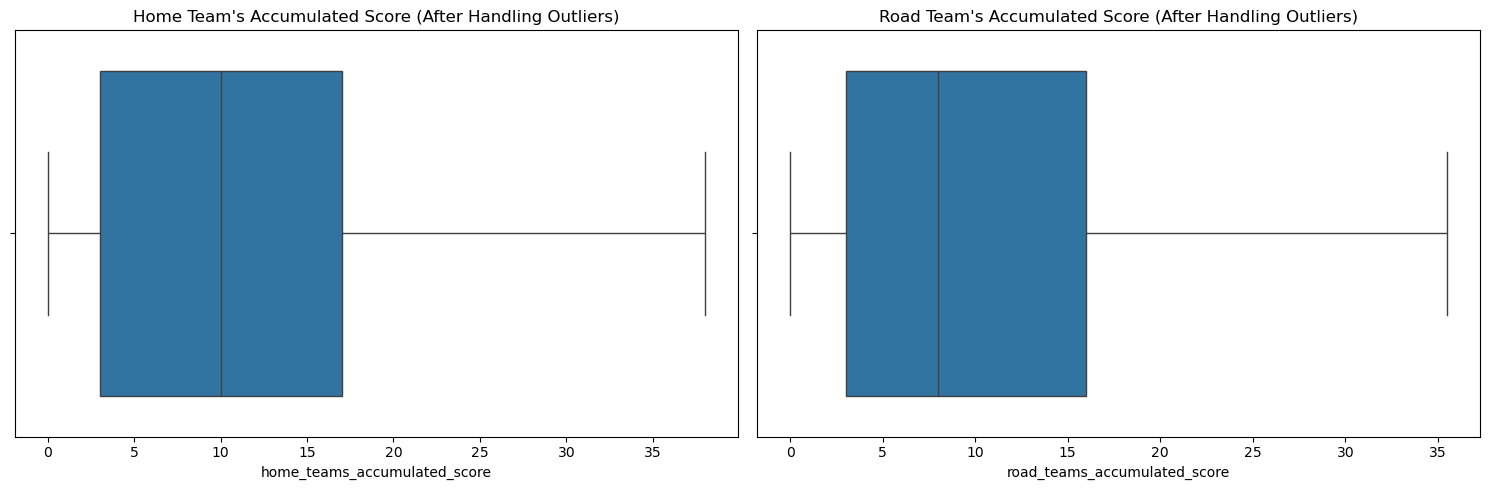

In [24]:
def handle_outliers(df, column, method='winsorize', threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    if method == 'winsorize':
        df[column] = np.clip(df[column], lower_bound, upper_bound)
    elif method == 'remove':
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    elif method == 'log':
        df[column] = np.log1p(df[column] - min(0, df[column].min()))
    
    return df

# Handle outliers for home team's accumulated score
data = handle_outliers(data, 'home_teams_accumulated_score', method='winsorize')

# Handle outliers for road team's accumulated score
data = handle_outliers(data, 'road_teams_accumulated_score', method='winsorize')

# Print summary statistics after handling outliers
print("\nDescriptive statistics after handling outliers:")
print(data[['home_teams_accumulated_score', 'road_teams_accumulated_score']].describe())

#visualize the data distribution after handling outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x=data['home_teams_accumulated_score'], ax=ax1)
ax1.set_title("Home Team's Accumulated Score (After Handling Outliers)")

sns.boxplot(x=data['road_teams_accumulated_score'], ax=ax2)
ax2.set_title("Road Team's Accumulated Score (After Handling Outliers)")

plt.tight_layout()
plt.show()

In [25]:
# Converting Categorical columns into numerical coln
# One-hot encode 'OFFENSIVE TEAM VENUE'
data = pd.get_dummies(data, columns=['offensive_team_venue_road_home_neutral'], prefix='Venue')

In [29]:

#Feature Engineering
# Create a feature for time pressure
data['time_pressure'] = ((data['quarter'] == 4) & (data['remaining_time_seconds'] <= 300)).astype(int)

# Create a binary feature for last 2 minutes of each half
data['two_minute_drill'] = (((data['quarter'] == 2) | (data['quarter'] == 4)) & (data['remaining_time_seconds'] <= 120)).astype(int)

# Calculate point differential
data['point_differential'] = data['road_teams_accumulated_score'] - data['home_teams_accumulated_score']
data.loc[data['Venue_Road'], 'point_differential'] *= -1  # Flip for road teams

# Create a feature for close game
data['close_game'] = (abs(data['point_differential']) <= 7).astype(int)

# Create a feature for trailing team
data['is_trailing'] = (data['point_differential'] < 0).astype(int)

# Create a feature for long yardage situation
data['long_yardage'] = (data['to_go'] >= 10).astype(int)

# Create a feature for short yardage situation
data['short_yardage'] = (data['to_go'] <= 2).astype(int)

# Create a feature for third or fourth down
data['third_or_fourth_down'] = ((data['down'] == 3) | (data['down'] == 4)).astype(int)

# Interaction between down and distance
data['down_distance_interaction'] = data['down'] * data['to_go']

# Interaction between field position and time
data['field_time_interaction'] = data['yard_line_0-100'] * data['remaining_time_seconds']

In [31]:
data.dtypes

date                                                        object
week#                                                        int64
play-id                                                      int64
drive-id                                                     int64
quarter                                                      int64
down                                                       float64
to_go                                                        int64
yard_line_0-100                                              int64
offensive_team                                              object
defensive_team                                              object
road_teams_accumulated_score                               float64
home_teams_accumulated_score                                 int64
scoredifferential(home_teams_score)_-(road_teams_score)      int64
play_type                                                   object
yards_gained                                               flo

In [41]:
# Convert relevant columns to integer type
data['down'] = data['down'].astype('int64')
data['yards_gained'] = data['yards_gained'].round().astype('int64')
data['road_teams_accumulated_score'] = data['road_teams_accumulated_score'].astype('int64')
data['home_teams_accumulated_score'] = data['home_teams_accumulated_score'].astype('int64')
data['field_time_interaction'] = data['field_time_interaction'].astype('float64')
data['scoredifferential(home_teams_score)_-(road_teams_score)'] = data['scoredifferential(home_teams_score)_-(road_teams_score)'].astype('float64')

#recheck the datatypes
data.dtypes

date                                                        object
week#                                                        int64
play-id                                                      int64
drive-id                                                     int64
quarter                                                      int64
down                                                         int64
to_go                                                        int64
yard_line_0-100                                              int64
offensive_team                                              object
defensive_team                                              object
road_teams_accumulated_score                                 int64
home_teams_accumulated_score                                 int64
scoredifferential(home_teams_score)_-(road_teams_score)    float64
play_type                                                   object
yards_gained                                                 i

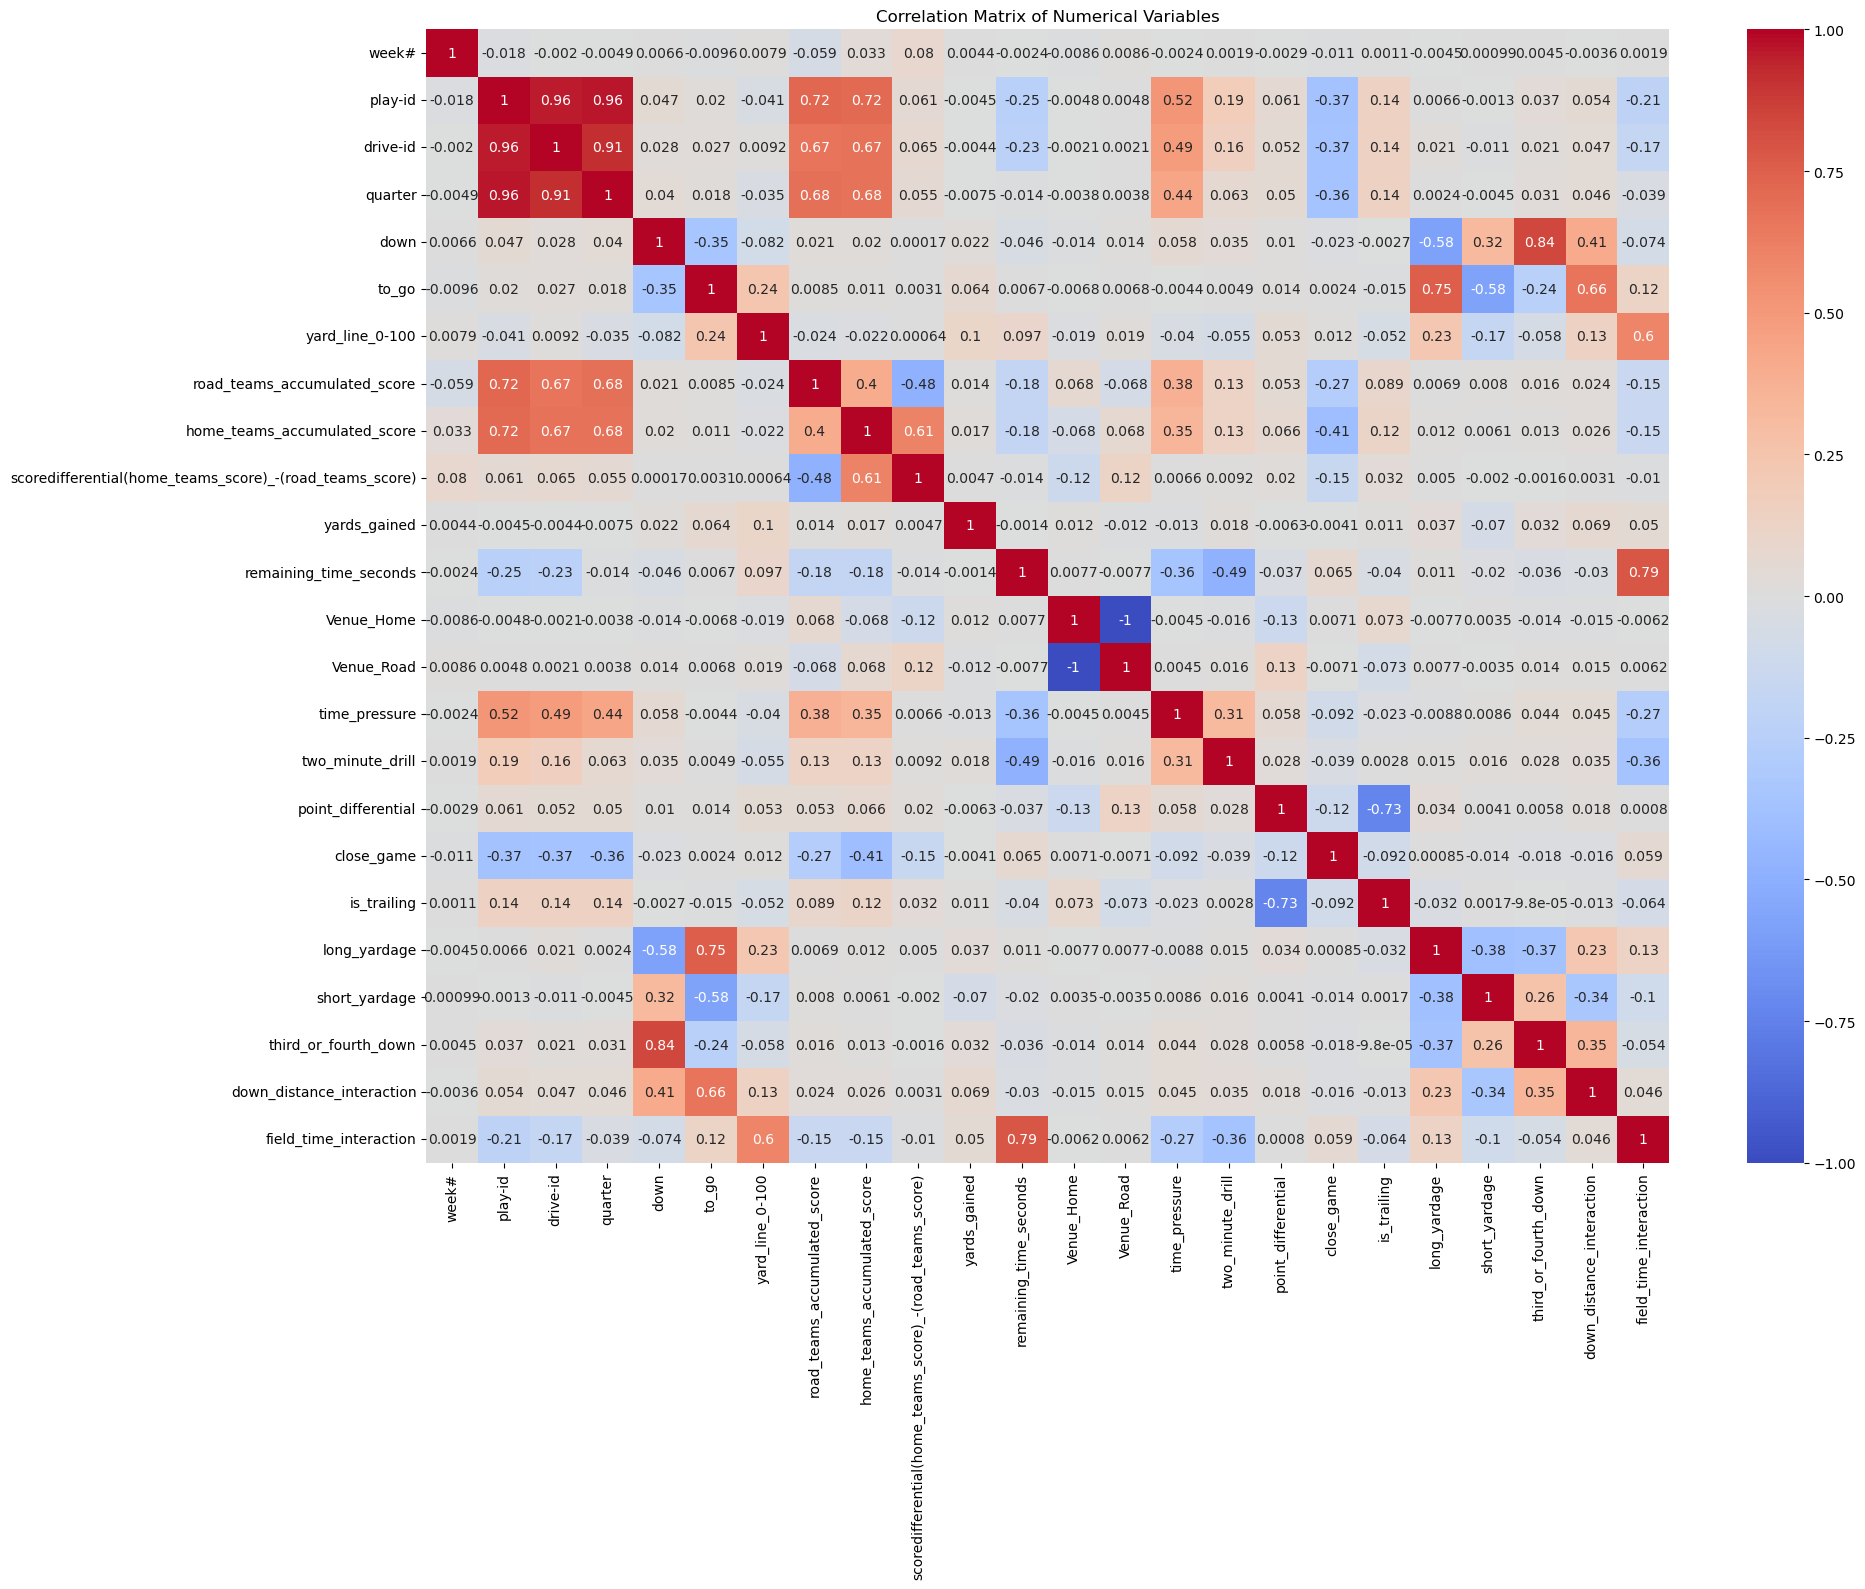

In [43]:
#Plotting the correlation matrix
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['int32', 'int64', 'float64', 'bool']).columns

# Calculate the correlation matrix
correlation_matrix = data[numeric_columns].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

In [45]:
#Conducting VIF
# Select only the numeric columns for VIF calculation
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Create a dataframe with only the numeric columns
X = data[numeric_columns]

# Add a constant term to the features (required for statsmodels VIF calculation)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort the dataframe by VIF values
vif_data = vif_data.sort_values("VIF", ascending=False)

# Display the VIF values
print(vif_data)

# Optionally, you can set a threshold to identify high VIF values
high_vif = vif_data[vif_data["VIF"] > 5]  # Adjust the threshold as needed
print("\nFeatures with high VIF (> 5):")
print(high_vif)

                                              Feature         VIF
0                                               const  110.889575
2                                             play-id   99.446956
10  scoredifferential(home_teams_score)_-(road_tea...   72.623534
9                        home_teams_accumulated_score   68.470041
4                                             quarter   56.575810
8                        road_teams_accumulated_score   55.345332
3                                            drive-id   13.699002
6                                               to_go   13.280675
5                                                down   12.381192
21                          down_distance_interaction   11.404755
12                             remaining_time_seconds   10.030903
22                             field_time_interaction    9.324448
20                               third_or_fourth_down    3.869733
7                                     yard_line_0-100    3.718039
18        

In [55]:
# Select numeric columns for VIF calculation
numeric_columns = ['down', 
                  'to_go', 
                  'yard_line_0-100',
                  'point_differential', 
                  'remaining_time_seconds',
                  'down_distance_interaction', 
                  'field_time_interaction',
                  'scoredifferential(home_teams_score)_-(road_teams_score)',
                  'quarter', 'road_teams_accumulated_score', 'road_teams_accumulated_score']

# Create dataframe with numeric columns
X = data[numeric_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Add constant term
X_scaled = sm.add_constant(X_scaled)

# Calculate VIF for standardized features
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Sort by VIF values
vif_data = vif_data.sort_values("VIF", ascending=False)

print("Standardized VIF values:")
print(vif_data)

# Show high VIF features
print("\nFeatures with high VIF (> 5):")
print(vif_data[vif_data["VIF"] > 5])


Standardized VIF values:
                                              Feature        VIF
10                       road_teams_accumulated_score        inf
11                       road_teams_accumulated_score        inf
6                           down_distance_interaction  10.435594
2                                               to_go  10.074826
7                              field_time_interaction   9.228725
1                                                down   6.636941
5                              remaining_time_seconds   6.164826
3                                     yard_line_0-100   3.629397
9                                             quarter   3.115454
8   scoredifferential(home_teams_score)_-(road_tea...   2.141901
4                                  point_differential   1.009529
0                                               const   1.000000

Features with high VIF (> 5):
                         Feature        VIF
10  road_teams_accumulated_score        inf
11  road_te

C:\Users\purva\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


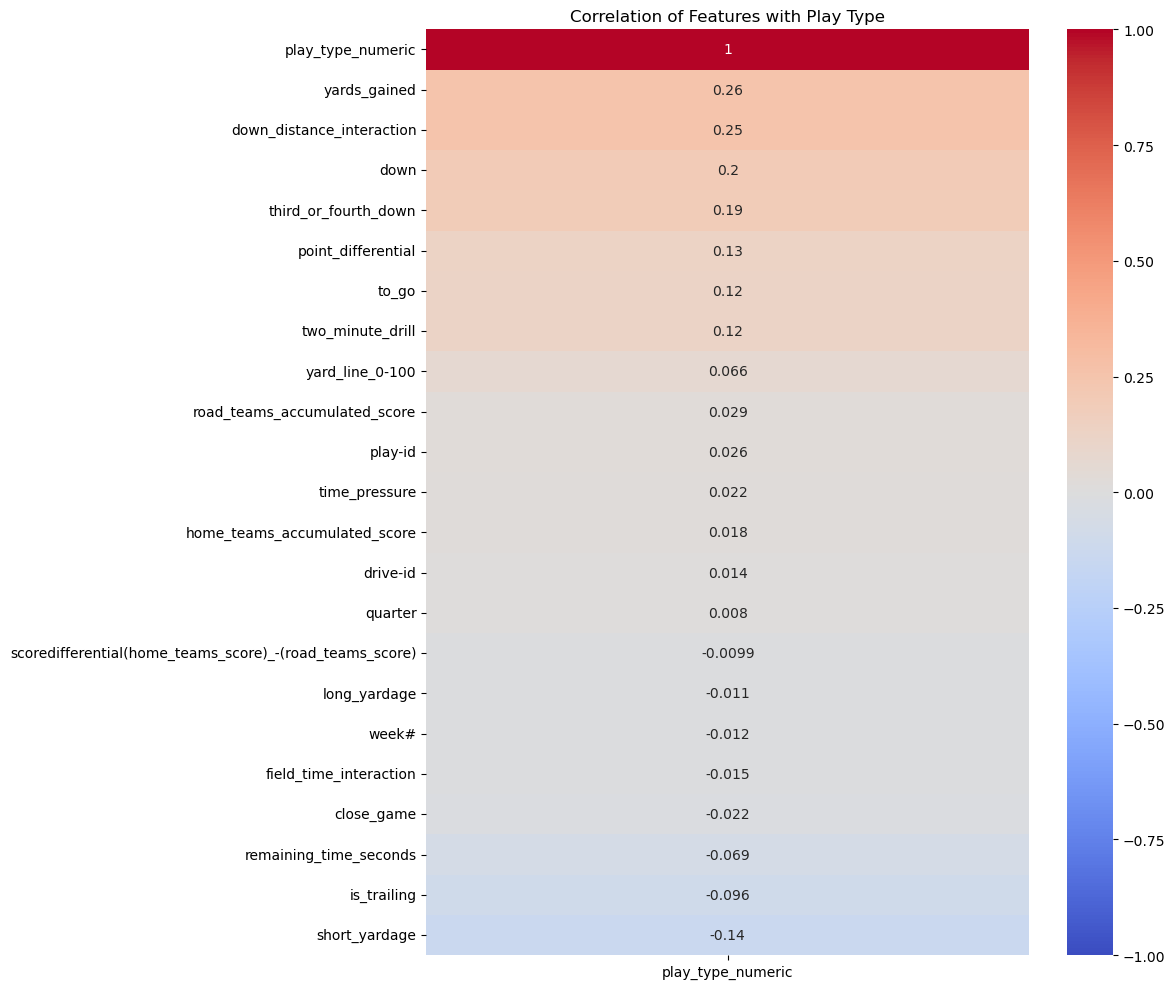

play_type_numeric                                          1.000000
yards_gained                                               0.255993
down_distance_interaction                                  0.253893
down                                                       0.195427
third_or_fourth_down                                       0.189613
point_differential                                         0.125860
to_go                                                      0.120221
two_minute_drill                                           0.119268
yard_line_0-100                                            0.065784
road_teams_accumulated_score                               0.028662
play-id                                                    0.025546
time_pressure                                              0.022206
home_teams_accumulated_score                               0.018328
drive-id                                                   0.013904
quarter                                         

In [47]:
# Convert Play_Type to numeric
data['play_type_numeric'] = (data['play_type'] == 'Pass').astype(int)

# Calculate correlation with other numeric variables
numeric_columns = data.select_dtypes(include=['int32', 'int64', 'float64']).columns
correlation_with_target = data[numeric_columns].corr()['play_type_numeric'].sort_values(ascending=False)


# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of Features with Play Type')
plt.tight_layout()
plt.show()

# Print the correlation values
print(correlation_with_target)


In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



KNN Results:
Accuracy: 0.6464
Precision: 0.6939
Recall: 0.7050
F1-score: 0.6994


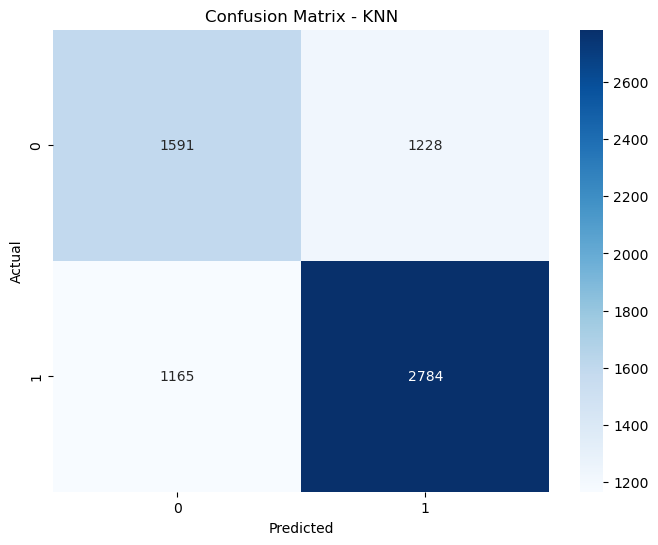


Logistic Regression Results:
Accuracy: 0.6451
Precision: 0.6814
Recall: 0.7359
F1-score: 0.7076


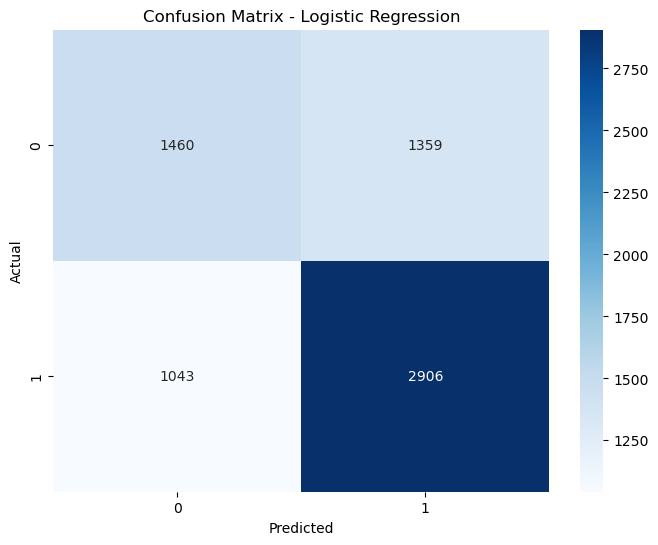


SVM Results:
Accuracy: 0.6668
Precision: 0.7298
Recall: 0.6812
F1-score: 0.7046


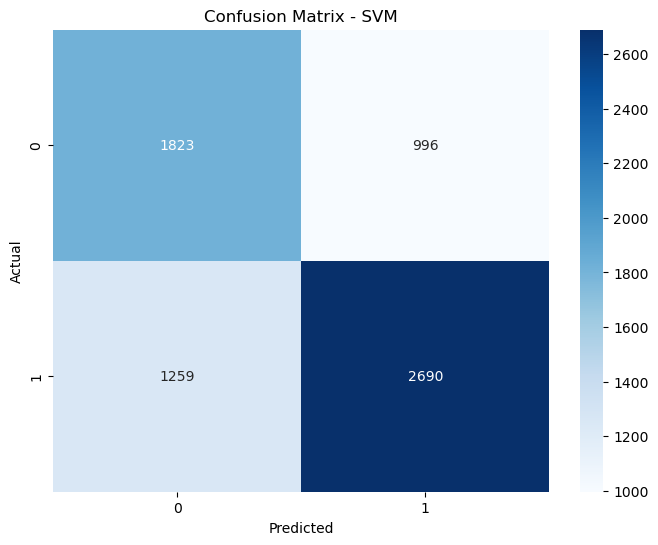


Decision Tree Results:
Accuracy: 0.6104
Precision: 0.6730
Recall: 0.6462
F1-score: 0.6593


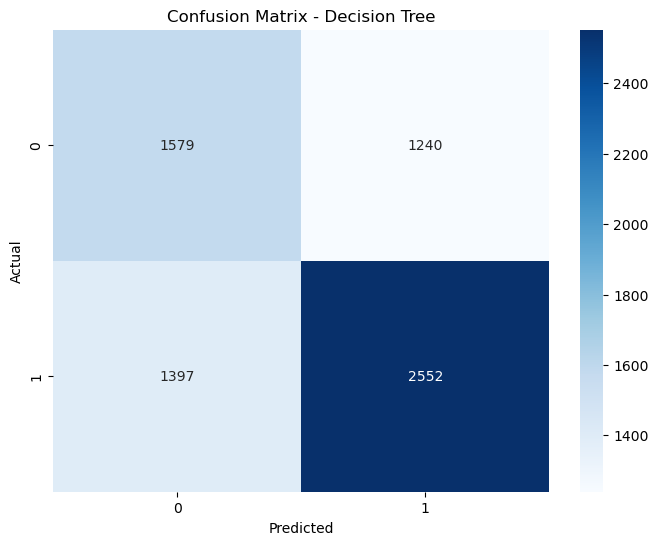


Random Forest Results:
Accuracy: 0.6596
Precision: 0.7052
Recall: 0.7159
F1-score: 0.7105


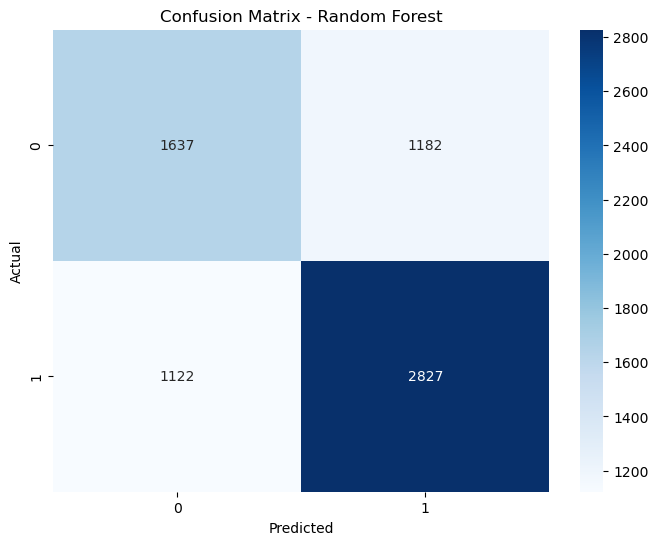


XGBoost Results:
Accuracy: 0.6695
Precision: 0.7171
Recall: 0.7159
F1-score: 0.7165


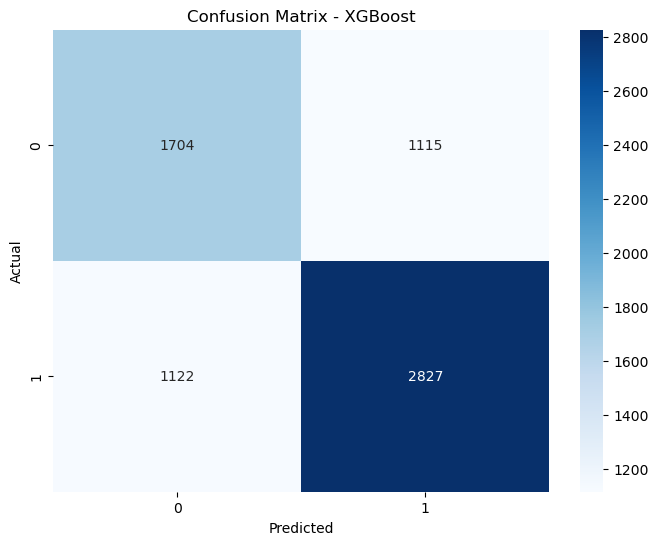

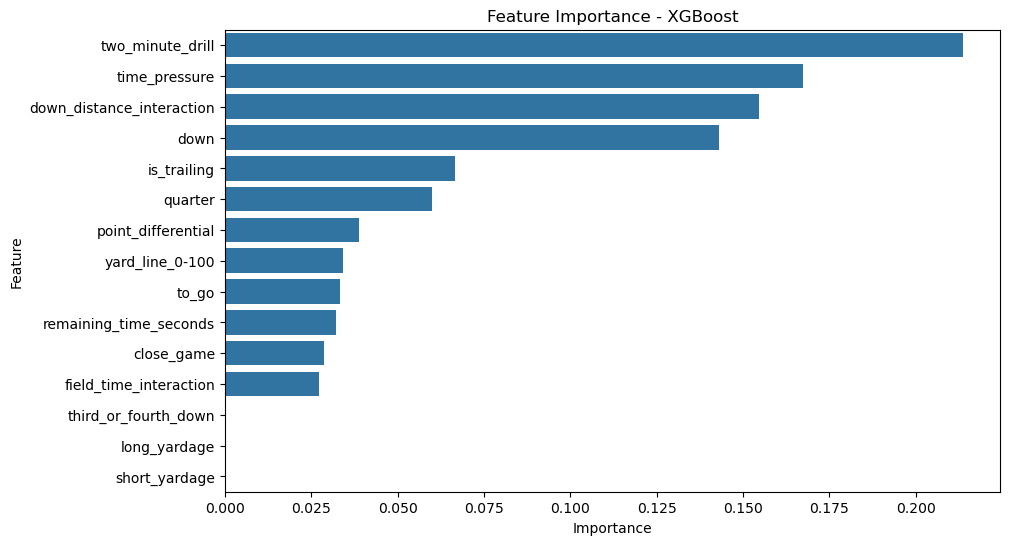

In [164]:
# Select relevant features
features = ['down_distance_interaction', 'to_go', 'field_time_interaction',  'quarter',
            'down', 'remaining_time_seconds', 'third_or_fourth_down', 'yard_line_0-100', 'long_yardage',
            'is_trailing', 'point_differential', 'short_yardage', 'time_pressure', 'two_minute_drill', 'close_game']

X = data[features]
y = data['play_type_numeric']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Function to evaluate and display results
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    # Fit the model on training data
    model.fit(X_train, y_train)
    
    # Get predictions on validation data
    y_pred = model.predict(X_val)
    
    # Calculate metrics using validation data
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix using validation data
    cm = confusion_matrix(y_val, y_pred)  # Corrected line
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Initialize models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    evaluate_model(model, X_train, X_val, y_train, y_val, name)

# Feature importance for XGBoost
rf_model = models['XGBoost']
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - XGBoost')
plt.show()


.
.
.
.
TEST DATA
.
.
.
.

In [66]:
# Load the test data
test_data = pd.read_csv('Test_Data.csv')

print(test_data.dtypes)

DATE                                                                      object
WEEK#                                                                      int64
ROAD TEAM                                                                 object
HOME TEAM                                                                 object
PLAY-ID                                                                    int64
DRIVE-ID                                                                   int64
QUARTER                                                                    int64
REMAINING TIME IN THE QUARTER (mm:ss)                                     object
DOWN                                                                     float64
TO GO                                                                      int64
YARD LINE 0-100                                                            int64
OFFENSIVE TEAM                                                            object
DEFENSIVE TEAM              

In [68]:
#removing \n from the columns
test_data.columns = test_data.columns.str.replace('\n', '')

# Change column names to lower case and remove spaces
new_columns = test_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = new_columns

# remove apostrophe (')
test_data.columns = test_data.columns.str.replace("'", "", regex=False)

#remove commas
test_data.columns = test_data.columns.str.replace(',', '_', regex=False)

print(test_data.columns)


Index(['date', 'week#', 'road_team', 'home_team', 'play-id', 'drive-id',
       'quarter', 'remaining_time_in_the_quarter_(mm:ss)', 'down', 'to_go',
       'yard_line_0-100', 'offensive_team', 'defensive_team',
       'offensive_team_venue_road_home_neutral', 'points_scoredby_either_team',
       'road_teams_accumulated_score', 'home_teams_accumulated_score',
       'scoredifferential(home_teams_score)_-(road_teams_score)', 'play_type',
       'yards_gained', 'pass_outcome_complete_incomplete_sack',
       'pass_length_short_deep', 'pass_location_left_middle_right',
       'air_yards', 'yards_after_catch_(yac)',
       'run_location_left_middle_right',
       'touchdown_pass/offensive_td_rush/offensive_td_return/defensive_td'],
      dtype='object')


In [70]:
null_values = test_data.isnull().sum()

# Calculate the percentage of null values
null_percentage = (null_values / len(test_data)) * 100

# Create a dataframe with null value information
null_info = pd.DataFrame({
    'Null Count': null_values,
    'Null Percentage': null_percentage
})

# Sort the dataframe by null count in descending order
null_info = null_info.sort_values('Null Count', ascending=False)

# Display only columns with null values
null_info = null_info[null_info['Null Count'] > 0]

print("Columns with null values:")
print(null_info)



Columns with null values:
                                                    Null Count  \
touchdown_pass/offensive_td_rush/offensive_td_r...        1569   
points_scoredby_either_team                               1565   
yards_after_catch_(yac)                                   1024   
run_location_left_middle_right                             993   
air_yards                                                  706   
pass_location_left_middle_right                            706   
pass_length_short_deep                                     706   
pass_outcome_complete_incomplete_sack                      670   
yards_gained                                               389   
down                                                         5   

                                                    Null Percentage  
touchdown_pass/offensive_td_rush/offensive_td_r...        95.496044  
points_scoredby_either_team                               95.252587  
yards_after_catch_(yac)              

In [72]:
# 1. Drop columns with >50% null values
columns_to_drop = [
    'touchdown_pass/offensive_td_rush/offensive_td_return/defensive_td',
    'points_scoredby_either_team',
    'yards_after_catch_(yac)',
    'run_location_left_middle_right', 
    'air_yards',
    'pass_location_left_middle_right',  
    'pass_length_short_deep',  
    'pass_outcome_complete_incomplete_sack'
    
]
test_data = test_data.drop(columns=columns_to_drop)

#handling missing values for yards_gained variable
for play_type in test_data['play_type'].unique():
    median_yards = test_data[test_data['play_type'] == play_type]['yards_gained'].median()
    test_data.loc[(test_data['play_type'] == play_type) & (test_data['yards_gained'].isnull()), 'yards_gained'] = median_yards

#handling missing values for down variable
test_data = test_data.dropna(subset=['down'])

#rechecking the null values
null = test_data.isnull().sum()
print(null)


date                                                       0
week#                                                      0
road_team                                                  0
home_team                                                  0
play-id                                                    0
drive-id                                                   0
quarter                                                    0
remaining_time_in_the_quarter_(mm:ss)                      0
down                                                       0
to_go                                                      0
yard_line_0-100                                            0
offensive_team                                             0
defensive_team                                             0
offensive_team_venue_road_home_neutral                     0
road_teams_accumulated_score                               0
home_teams_accumulated_score                               0
scoredifferential(home_t

In [74]:
test_data.shape

(1638, 19)

In [76]:
#convert the 'remaining time seconds' column from minutes to seconds 
def convert_to_seconds(time_str):
    parts = time_str.split(':')
    return int(parts[0]) * 60 + int(parts[1])

test_data['remaining_time_seconds'] = test_data['remaining_time_in_the_quarter_(mm:ss)'].apply(convert_to_seconds)

print(test_data[['remaining_time_in_the_quarter_(mm:ss)', 'remaining_time_seconds']].head())

test_data = test_data.drop(columns = ['remaining_time_in_the_quarter_(mm:ss)'])

  remaining_time_in_the_quarter_(mm:ss)  remaining_time_seconds
0                                 15:00                     900
1                                 14:37                     877
2                                 13:59                     839
3                                 13:17                     797
4                                 12:25                     745


In [78]:
#Converting the Categorical Variables
# One-hot encode 'OFFENSIVE TEAM VENUE'
test_data = pd.get_dummies(test_data, columns=['offensive_team_venue_road_home_neutral'], prefix='Venue')


#Standardizing the variables
scaler = StandardScaler()
test_data[['yard_line_0-100', 'scoredifferential(home_teams_score)_-(road_teams_score)']] = scaler.fit_transform(test_data[['yard_line_0-100', 'scoredifferential(home_teams_score)_-(road_teams_score)']])

#Feature Engineering
# Create a feature for time pressure
test_data['time_pressure'] = ((test_data['quarter'] == 4) & (test_data['remaining_time_seconds'] <= 300)).astype(int)

# Create a binary feature for last 2 minutes of each half
test_data['two_minute_drill'] = (((test_data['quarter'] == 2) | (test_data['quarter'] == 4)) & (test_data['remaining_time_seconds'] <= 120)).astype(int)

# Calculate point differential
test_data['point_differential'] = test_data['road_teams_accumulated_score'] - test_data['home_teams_accumulated_score']
test_data.loc[test_data['Venue_Road'], 'point_differential'] *= -1  # Flip for road teams

# Create a feature for close game
test_data['close_game'] = (abs(test_data['point_differential']) <= 7).astype(int)

# Create a feature for trailing team
test_data['is_trailing'] = (test_data['point_differential'] < 0).astype(int)


# Create a feature for long yardage situation
test_data['long_yardage'] = (test_data['to_go'] >= 10).astype(int)

# Create a feature for short yardage situation
test_data['short_yardage'] = (test_data['to_go'] <= 2).astype(int)

# Create a feature for third or fourth down
test_data['third_or_fourth_down'] = ((test_data['down'] == 3) | (test_data['down'] == 4)).astype(int)

# Interaction between down and distance
test_data['down_distance_interaction'] = test_data['down'] * test_data['to_go']

# Interaction between field position and time
test_data['field_time_interaction'] = test_data['yard_line_0-100'] * test_data['remaining_time_seconds']


In [80]:
test_data.dtypes

date                                                        object
week#                                                        int64
road_team                                                   object
home_team                                                   object
play-id                                                      int64
drive-id                                                     int64
quarter                                                      int64
down                                                       float64
to_go                                                        int64
yard_line_0-100                                            float64
offensive_team                                              object
defensive_team                                              object
road_teams_accumulated_score                                 int64
home_teams_accumulated_score                                 int64
scoredifferential(home_teams_score)_-(road_teams_score)    flo

In [82]:
# Convert relevant columns to integer type
data['down'] = data['down'].astype('int64')
data['yards_gained'] = data['yards_gained'].round().astype('int64')

#recheck the datatypes
data.dtypes

date                                                        object
week#                                                        int64
play-id                                                      int64
drive-id                                                     int64
quarter                                                      int64
down                                                         int64
to_go                                                        int64
yard_line_0-100                                              int64
offensive_team                                              object
defensive_team                                              object
road_teams_accumulated_score                                 int64
home_teams_accumulated_score                                 int64
scoredifferential(home_teams_score)_-(road_teams_score)    float64
play_type                                                   object
yards_gained                                                 i

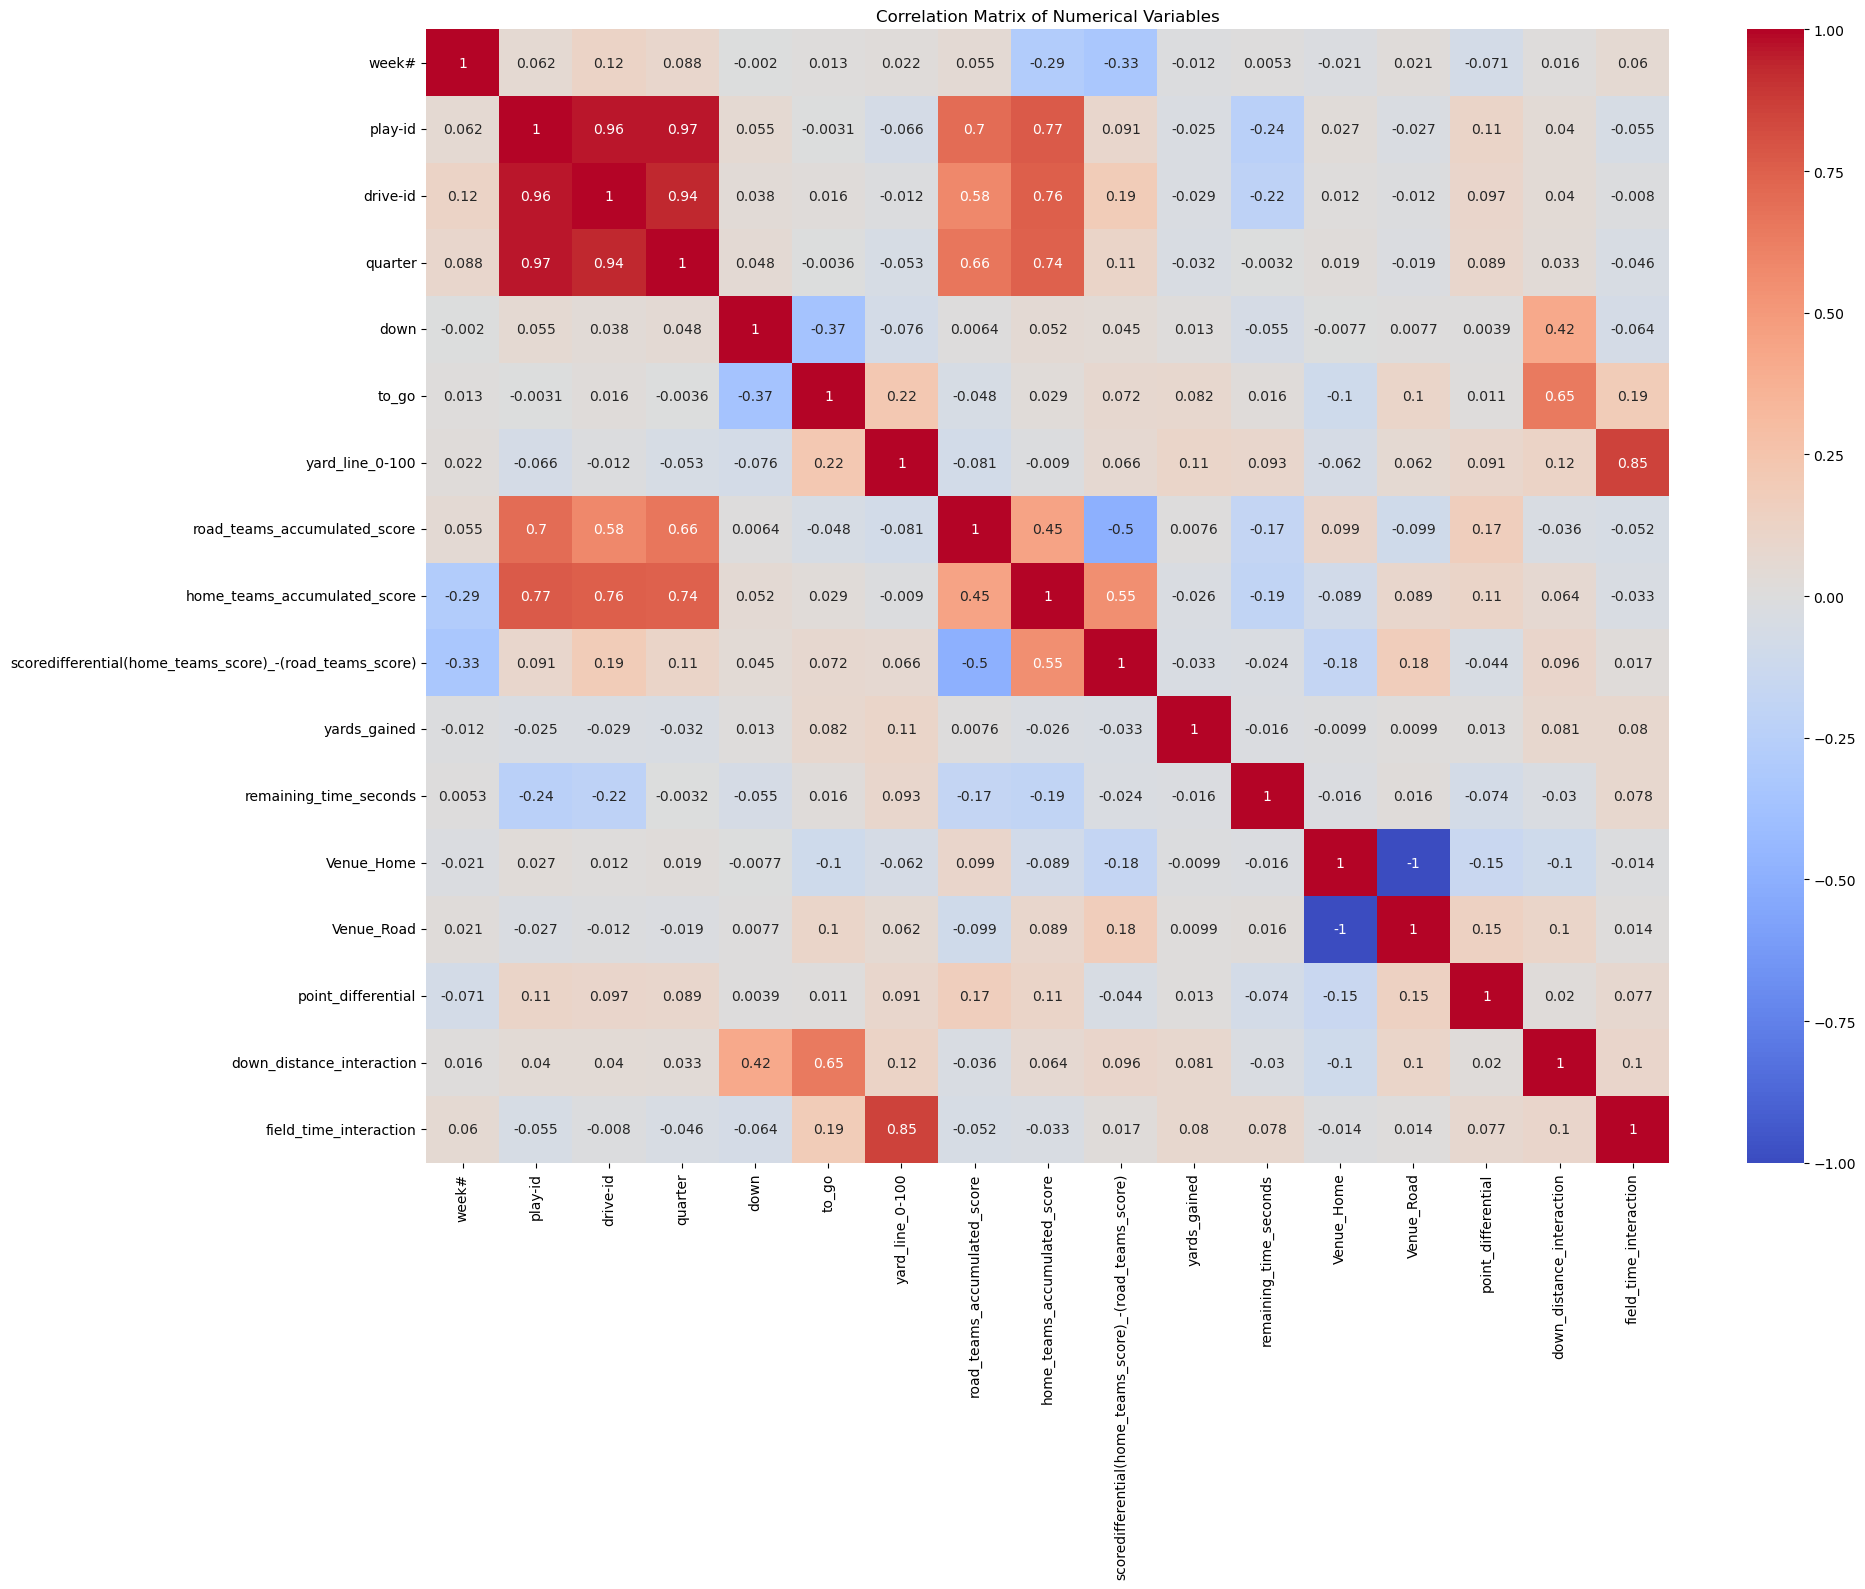

In [84]:
#Plot Correlation Matrix
# Select only numeric columns
numeric_columns = test_data.select_dtypes(include=['int64', 'float64', 'bool']).columns

# Calculate the correlation matrix
correlation_matrix = test_data[numeric_columns].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

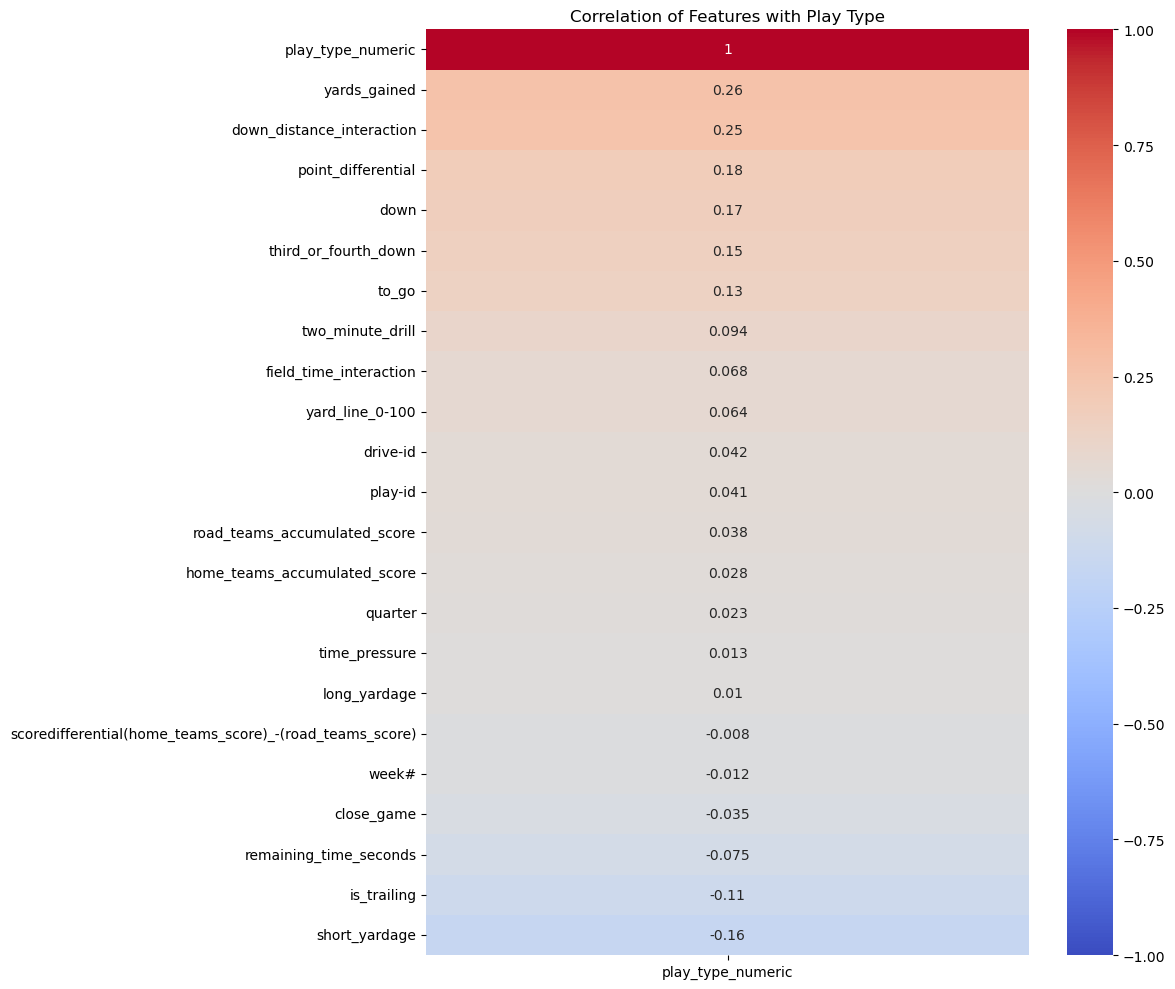

play_type_numeric                                          1.000000
yards_gained                                               0.264632
down_distance_interaction                                  0.254226
point_differential                                         0.182171
down                                                       0.170094
third_or_fourth_down                                       0.154378
to_go                                                      0.133877
two_minute_drill                                           0.094224
field_time_interaction                                     0.067907
yard_line_0-100                                            0.063997
drive-id                                                   0.042070
play-id                                                    0.041478
road_teams_accumulated_score                               0.038242
home_teams_accumulated_score                               0.028395
quarter                                         

In [86]:
# Convert Play_Type to numeric
test_data['play_type_numeric'] = (test_data['play_type'] == 'Pass').astype(int)

# Calculate correlation with other numeric variables
numeric_columns = test_data.select_dtypes(include=['int32', 'int64', 'float64']).columns
correlation_with_target = test_data[numeric_columns].corr()['play_type_numeric'].sort_values(ascending=False)


# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of Features with Play Type')
plt.tight_layout()
plt.show()

# Print the correlation values
print(correlation_with_target)

Evaluating SVM on test data...

SVM model Test Results:
Accuracy: 0.6691
Precision: 0.7618
Recall: 0.6552
F1-score: 0.7045


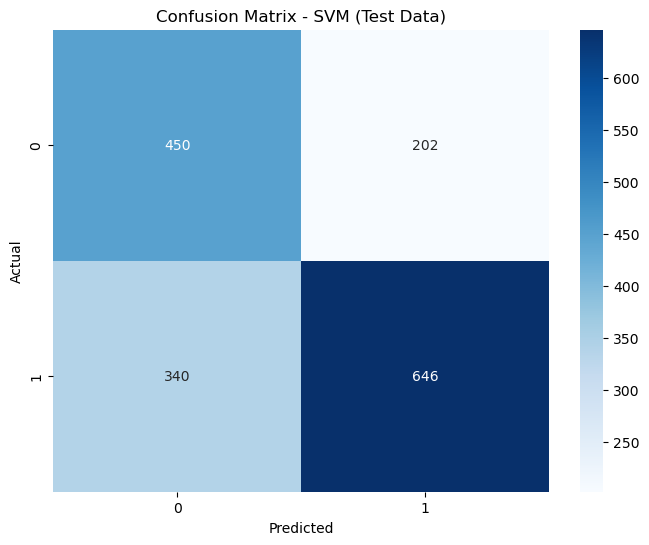

In [174]:

# Select relevant features
X_test = test_data[features]

# Scale the features using the same scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# Assuming 'play_type_numeric' is available in test data for evaluation
y_test = test_data['play_type_numeric']

svm_model = models['SVM']
def evaluate_svm(model, X_test, y_test):
    # Get predictions on test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics using test data
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\nSVM model Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix using test data
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - SVM (Test Data)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate SVM model
print("Evaluating SVM on test data...")
evaluate_svm(svm_model, X_test_scaled, y_test)


Evaluating XGBoost on test data...

XGBoost model Test Results:
Accuracy: 0.6545
Precision: 0.7333
Recall: 0.6694
F1-score: 0.6999


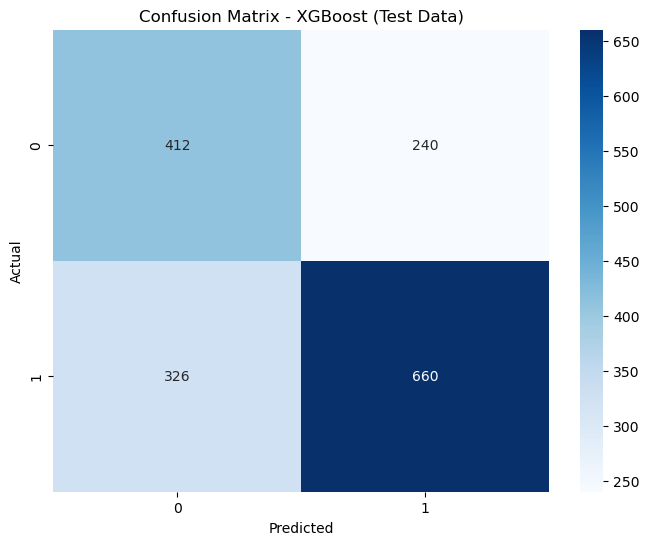

In [176]:

# Select relevant features
X_test = test_data[features]

# Scale the features using the same scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# Assuming 'play_type_numeric' is available in test data for evaluation
y_test = test_data['play_type_numeric']

svm_model = models['XGBoost']
def evaluate_xgb(model, X_test, y_test):
    # Get predictions on test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics using test data
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\nXGBoost model Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix using test data
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - XGBoost (Test Data)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate XGBoost model
print("Evaluating XGBoost on test data...")
evaluate_xgb(svm_model, X_test_scaled, y_test)
